In [83]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib.figure import Figure
import math
import imageio
import datetime
from os import walk
from scipy import stats

from ConvLSTM import ConvLSTM
from SlimAutoencoder import SlimAutoencoderBuilder
from rea_cd_autoencoder import REA_CD_Autoencoder
from dataloader import hillsborough_county_rea_cd_encoded as hc_rea_cd_encoded
from datawrangler import DataWrangler

import multiprocessing
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
sales_and_parcels = pd.read_pickle("/tf/DataSources/sales_and_parcels/hillsborough_county.pickle")

In [3]:
sales_and_parcels.head()

PIN_x       FOLIO DOR_CODE    NBHC_x  \
1369672  U-19-29-21-ZZZ-000004-07380.0  0855870200     0100  220005.0   
1354557  U-35-28-21-ZZZ-000003-87990.0  0839190200     0200  221001.0   
2064848  T-15-28-19-54X-000009-00007.0  2007630187     0400  817029.0   
2110431  P-20-28-22-5B7-000002-00005.0  2056440000     0100  221008.0   
592814   U-33-28-19-1M2-000000-00006.3  0398100200     0000  218008.0   

           S_DATE_x VI_x QU REA_CD  S_AMT_x SUB_x     STR S_TYPE  OR_BK OR_PG  \
1369672  1901-12-01    I  U     38    100.0   ZZZ  192921     DD  06468  0182   
1354557  1902-02-01    V  U     05  22500.0   ZZZ  352821     WD  06498  1093   
2064848  1902-03-01    I  U     38   1000.0   54X  152819     CT  06560  1266   
2110431  1903-05-01    I  U     38    100.0   5B7  202822     QC  06978  1229   
592814   1904-11-01    V  U     05    100.0   1M2  332819     WD  04442  0588   

        GRANTOR GRANTEE   DOC_NUM  TYPE                          PIN_y DOR_C  \
1369672    None    None  91259894  None  U-19-29-21-ZZZ-000004-07380.0  0100   
1354557    None    None  92017529  None  U-35-28-21-ZZZ-000003-87990.0  0200   
2064848    None    None  92065551  None  T-15-28-19-54X-000009-00007.0  0400   
2110431    None    None  93111152  None  P-20-28-22-5B7-000002-00005.0  0100   
592814     None    None      None  None  U-33-28-19-1M2-000000-00006.3  0000   

                          OWNER                  ADDR_1 ADDR_2  \
1369672   136 N SAINT CLOUD LLC       4252 GREEN KEY RD   None   
1354557   JOSE A SANTIAGO ET AL       1412 WILKINSON DR   None   
2064848       ARRIE ADEL POTTER  11334 STRATTON PARK DR   None   
2110431  JAMES AND JAMIE HUDSON      1306 N FRANKLIN ST   None   
592814        MYRNAMAE ENGLETON    6002 N 50TH ST APT A   None   

                    CITY STATE         ZIP COUNTRY SUB_y  \
1369672  NEW PORT RICHEY    FL  34652-2074    None   ZZZ   
1354557       PLANT CITY    FL  33566-7917    None   ZZZ   
2064848            TAMPA    FL  33617-2392    None   54X   
2110431       PLANT CITY    FL  33563-2252    None   5B7   
592814             TAMPA    FL  33610-3941    None   1M2   

                      SITE_ADDR       SITE_CITY SITE_ZIP  \
1369672     136 SAINT CLOUD AVE         VALRICO    33594   
1354557       1412 WILKINSON DR      PLANT CITY    33566   
2064848  11334 STRATTON PARK DR  TEMPLE TERRACE    33617   
2110431      1306 N FRANKLIN ST      PLANT CITY    33563   
592814           6002 N 50TH ST           TAMPA    33610   

                                                    LEGAL1  \
1369672  BEG 25 FT W & 468.92 FT N OF SE COR OF SE 1/4 RUN   
1354557     COMM SW COR OF E 3/4 OF NE 1/4 OF SW 1/4 THN E   
2064848                     VICTORIA TERRACE A CONDOMINIUM   
2110431                                           OAK HILL   
592814                                    BENS SUBDIVISION   

                                                    LEGAL2  \
1369672     W 194 FT N 52 FT W 110 FT N 77 FT E 304 FT AND   
1354557  25 FT THN N 157.16 FT FOR POB THN CON N 244.85 FT   
2064848                                            PHASE 2   
2110431                                      LOT 5 BLOCK 2   
592814                    NORTH HALF OF LOT 6 LESS N 50 FT   

                                                 LEGAL3  \
1369672                                 S 131 FT TO POB   
1354557  THN N 88 DEG 54 MIN 39 SEC E 157.83 FTTHN S 20   
2064848                                          BLDG 9   
2110431                                            None   
592814                                             None   

                                                   LEGAL4   DBA  \
1369672                                              None  None   
1354557  DEG 34 MIN 03 SEC E 264.70 FT THN W 248.53 FT TO  None   
2064848                                            UNIT 7  None   
2110431                                              None  None   
592814                                               None  None   

   

In [125]:
df = sales_and_parcels.copy()
DW = DataWrangler()
df = DW.cleanZipCodes(df, 'SITE_ZIP')
zipcodes = df['SITE_ZIP'].unique()
display(df.head())
zipcodes    

PIN_x       FOLIO DOR_CODE    NBHC_x  \
1369672  U-19-29-21-ZZZ-000004-07380.0  0855870200     0100  220005.0   
1354557  U-35-28-21-ZZZ-000003-87990.0  0839190200     0200  221001.0   
2064848  T-15-28-19-54X-000009-00007.0  2007630187     0400  817029.0   
2110431  P-20-28-22-5B7-000002-00005.0  2056440000     0100  221008.0   
592814   U-33-28-19-1M2-000000-00006.3  0398100200     0000  218008.0   

           S_DATE_x VI_x QU REA_CD  S_AMT_x SUB_x     STR S_TYPE  OR_BK OR_PG  \
1369672  1901-12-01    I  U     38    100.0   ZZZ  192921     DD  06468  0182   
1354557  1902-02-01    V  U     05  22500.0   ZZZ  352821     WD  06498  1093   
2064848  1902-03-01    I  U     38   1000.0   54X  152819     CT  06560  1266   
2110431  1903-05-01    I  U     38    100.0   5B7  202822     QC  06978  1229   
592814   1904-11-01    V  U     05    100.0   1M2  332819     WD  04442  0588   

        GRANTOR GRANTEE   DOC_NUM  TYPE                          PIN_y DOR_C  \
1369672    None    None  91259894  None  U-19-29-21-ZZZ-000004-07380.0  0100   
1354557    None    None  92017529  None  U-35-28-21-ZZZ-000003-87990.0  0200   
2064848    None    None  92065551  None  T-15-28-19-54X-000009-00007.0  0400   
2110431    None    None  93111152  None  P-20-28-22-5B7-000002-00005.0  0100   
592814     None    None      None  None  U-33-28-19-1M2-000000-00006.3  0000   

                          OWNER                  ADDR_1 ADDR_2  \
1369672   136 N SAINT CLOUD LLC       4252 GREEN KEY RD   None   
1354557   JOSE A SANTIAGO ET AL       1412 WILKINSON DR   None   
2064848       ARRIE ADEL POTTER  11334 STRATTON PARK DR   None   
2110431  JAMES AND JAMIE HUDSON      1306 N FRANKLIN ST   None   
592814        MYRNAMAE ENGLETON    6002 N 50TH ST APT A   None   

                    CITY STATE         ZIP COUNTRY SUB_y  \
1369672  NEW PORT RICHEY    FL  34652-2074    None   ZZZ   
1354557       PLANT CITY    FL  33566-7917    None   ZZZ   
2064848            TAMPA    FL  33617-2392    None   54X   
2110431       PLANT CITY    FL  33563-2252    None   5B7   
592814             TAMPA    FL  33610-3941    None   1M2   

                      SITE_ADDR       SITE_CITY SITE_ZIP  \
1369672     136 SAINT CLOUD AVE         VALRICO    33594   
1354557       1412 WILKINSON DR      PLANT CITY    33566   
2064848  11334 STRATTON PARK DR  TEMPLE TERRACE    33617   
2110431      1306 N FRANKLIN ST      PLANT CITY    33563   
592814           6002 N 50TH ST           TAMPA    33610   

                                                    LEGAL1  \
1369672  BEG 25 FT W & 468.92 FT N OF SE COR OF SE 1/4 RUN   
1354557     COMM SW COR OF E 3/4 OF NE 1/4 OF SW 1/4 THN E   
2064848                     VICTORIA TERRACE A CONDOMINIUM   
2110431                                           OAK HILL   
592814                                    BENS SUBDIVISION   

                                                    LEGAL2  \
1369672     W 194 FT N 52 FT W 110 FT N 77 FT E 304 FT AND   
1354557  25 FT THN N 157.16 FT FOR POB THN CON N 244.85 FT   
2064848                                            PHASE 2   
2110431                                      LOT 5 BLOCK 2   
592814                    NORTH HALF OF LOT 6 LESS N 50 FT   

                                                 LEGAL3  \
1369672                                 S 131 FT TO POB   
1354557  THN N 88 DEG 54 MIN 39 SEC E 157.83 FTTHN S 20   
2064848                                          BLDG 9   
2110431                                            None   
592814                                             None   

                                                   LEGAL4   DBA  \
1369672                                              None  None   
1354557  DEG 34 MIN 03 SEC E 264.70 FT THN W 248.53 FT TO  None   
2064848                                            UNIT 7  None   
2110431                                              None  None   
592814                                               None  None   

   

array(['33594', '33566', '33617', '33563', '33610', '33569', '33602',
       '33565', '33548', '33611', '33584', '33559', '33511', '33609',
       '33605', '33619', '33567', '33510', '33634', '33547', '33604',
       '33629', '33573', '33637', '33715', '33624', '33612', '33570',
       '33578', '33603', '33607', '33606', '33614', '33616', '33556',
       '33534', '33618', '33527', '33592', '33598', '33613', '33810',
       '33572', '33579', '33625', '33596', '33549', '33615', '33635',
       '33540', '33558', '33626', '33586', '33647', '33860', '33587',
       '33503', '33849', '33636', '33544', '33854', '33599', '33575',
       '33601'], dtype=object)

In [136]:
folios_in_zip = dict()
for zip in zipcodes:
    df = sales_and_parcels[ sales_and_parcels['S_DATE_x'] >= '2000-01-01']
    records_from_zipcode = df[ df['SITE_ZIP'] == zip]
    num_folios =  records_from_zipcode['FOLIO'].unique().shape[0]
    print(f"{zip}: number_of_folios: {num_folios}")
    folios_in_zip[zip] = num_folios


33594: number_of_folios: 9891
33566: number_of_folios: 5981
33617: number_of_folios: 9728
33563: number_of_folios: 7497
33610: number_of_folios: 10421
33569: number_of_folios: 9164
33602: number_of_folios: 6030
33565: number_of_folios: 5098
33548: number_of_folios: 2324
33611: number_of_folios: 11527
33584: number_of_folios: 8625
33559: number_of_folios: 1884
33511: number_of_folios: 13794
33609: number_of_folios: 7135
33605: number_of_folios: 6787
33619: number_of_folios: 11580
33567: number_of_folios: 3557
33510: number_of_folios: 7711
33634: number_of_folios: 5097
33547: number_of_folios: 10419
33604: number_of_folios: 11778
33629: number_of_folios: 8736
33573: number_of_folios: 16497
33637: number_of_folios: 4073
33715: number_of_folios: 0
33624: number_of_folios: 11544
33612: number_of_folios: 10781
33570: number_of_folios: 12567
33578: number_of_folios: 18617
33603: number_of_folios: 6333
33607: number_of_folios: 7000
33606: number_of_folios: 5511
33614: number_of_folios: 11184
3

In [140]:
foreclosures_in_zip = dict()
for zip in zipcodes:
    df = sales_and_parcels[ sales_and_parcels['S_DATE_x'] >= '2000-01-01']
    records_from_zipcode = df[ df['SITE_ZIP'] == zip]
    #display(records_from_zipcode.head())
    foreclosures = records_from_zipcode[ records_from_zipcode['S_TYPE'] == 'CT']
    num_foreclosures = foreclosures.shape[0]
    print(f"{zip}: number_of_foreclosures: {num_foreclosures}")
    foreclosures_in_zip[zip] = num_foreclosures

33594: number_of_foreclosures: 2020
33566: number_of_foreclosures: 1107
33617: number_of_foreclosures: 2506
33563: number_of_foreclosures: 1605
33610: number_of_foreclosures: 3183
33569: number_of_foreclosures: 1467
33602: number_of_foreclosures: 977
33565: number_of_foreclosures: 707
33548: number_of_foreclosures: 292
33611: number_of_foreclosures: 1606
33584: number_of_foreclosures: 1591
33559: number_of_foreclosures: 294
33511: number_of_foreclosures: 2932
33609: number_of_foreclosures: 793
33605: number_of_foreclosures: 1927
33619: number_of_foreclosures: 2896
33567: number_of_foreclosures: 578
33510: number_of_foreclosures: 1543
33634: number_of_foreclosures: 1234
33547: number_of_foreclosures: 819
33604: number_of_foreclosures: 3891
33629: number_of_foreclosures: 535
33573: number_of_foreclosures: 670
33637: number_of_foreclosures: 1135
33715: number_of_foreclosures: 0
33624: number_of_foreclosures: 2519
33612: number_of_foreclosures: 2800
33570: number_of_foreclosures: 2656
3357

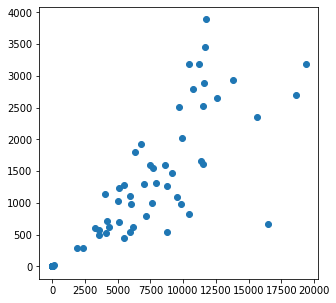

In [145]:
folios = []
foreclosures = []
for zip in folios_in_zip.keys():
    folios.append( folios_in_zip[zip] )
    foreclosures.append( foreclosures_in_zip[zip] )

fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.scatter(folios, foreclosures)

In [60]:
recent_convenyances = sales_and_parcels[ sales_and_parcels['S_DATE_x'] >= '2000-01-01']
recent_convenyances.shape

(1359189, 64)

In [86]:
DW = DataWrangler()
recent_convenyances = DW.cleanZipCodes(recent_convenyances, 'SITE_ZIP')

In [87]:
recent_convenyances['SITE_ZIP'].unique()

array(['33647', '33615', '33629', '33604', '33606', '33584', '33624',
       '33527', '33612', '33607', '33614', '33611', '33619', '33566',
       '33618', '33610', '33573', '33609', '33596', '33565', '33559',
       '33613', '33594', '33602', '33570', '33617', '33510', '33605',
       '33625', '33572', '33511', '33578', '33635', '33549', '33626',
       '33603', '33563', '33569', '33558', '33616', '33598', '33556',
       '33634', '33579', '33567', '33548', '33534', '33592', '33637',
       '33547', '33810', '33860', '33540', '33586', '33503', '33544',
       '33854', '33587', '33599', '33849', '33575', '33601'], dtype=object)

In [115]:
foreclosures_per_zip = dict()
for zip in recent_convenyances['SITE_ZIP'].unique():
    print(f'building foreclosures for {zip}...')
    df = recent_convenyances[ recent_convenyances['SITE_ZIP'] == zip ].copy()
    df['yearweek'] = pd.to_datetime(df['S_DATE_x']).dt.isocalendar().year + pd.to_datetime(df['S_DATE_x']).dt.month / 12
    df = df[ df['S_TYPE'] == 'CT']
    foreclosures_per_week = df.groupby('yearweek').count()
    if foreclosures_per_week.shape[0] == 0:
        print(f'skipping zip with zero foreflosures {zip}')
        continue
    median_foreclosure = np.median(foreclosures_per_week['PIN_x'])
    foreclosures_per_week['foreclosures'] = foreclosures_per_week['PIN_x'] / median_foreclosure
    foreclosures_per_zip[zip] = foreclosures_per_week


building foreclosures for 33647...
building foreclosures for 33615...
building foreclosures for 33629...
building foreclosures for 33604...
building foreclosures for 33606...
building foreclosures for 33584...
building foreclosures for 33624...
building foreclosures for 33527...
building foreclosures for 33612...
building foreclosures for 33607...
building foreclosures for 33614...
building foreclosures for 33611...
building foreclosures for 33619...
building foreclosures for 33566...
building foreclosures for 33618...
building foreclosures for 33610...
building foreclosures for 33573...
building foreclosures for 33609...
building foreclosures for 33596...
building foreclosures for 33565...
building foreclosures for 33559...
building foreclosures for 33613...
building foreclosures for 33594...
building foreclosures for 33602...
building foreclosures for 33570...
building foreclosures for 33617...
building foreclosures for 33510...
building foreclosures for 33605...
building foreclosure

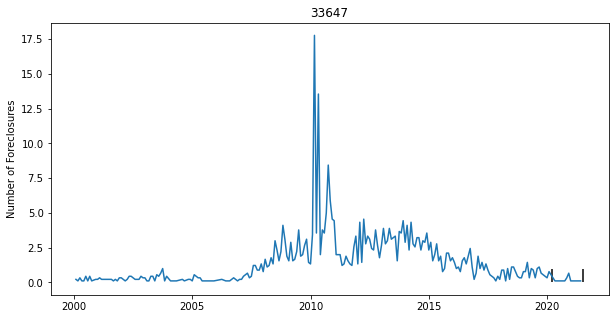

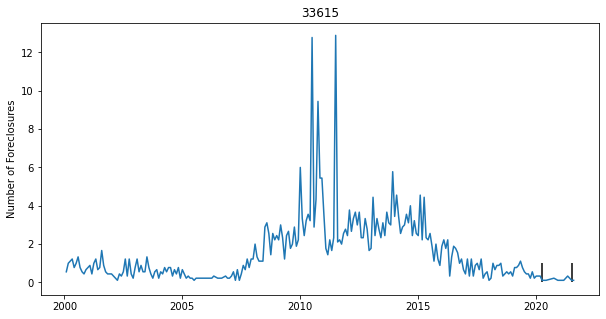

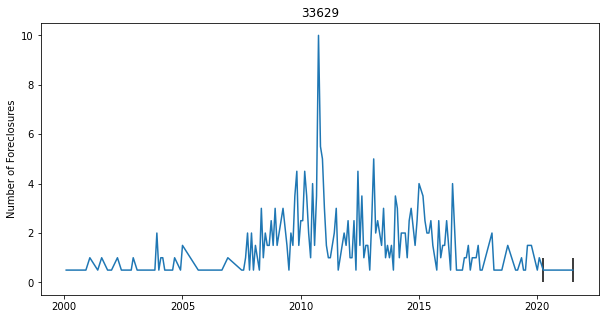

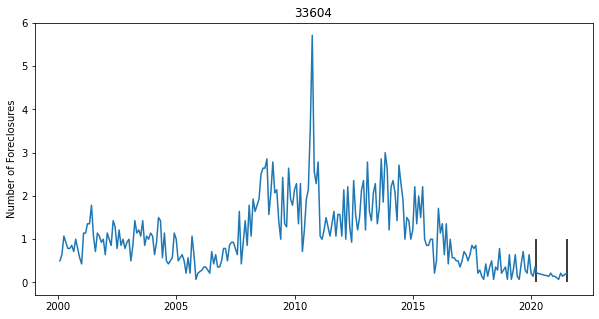

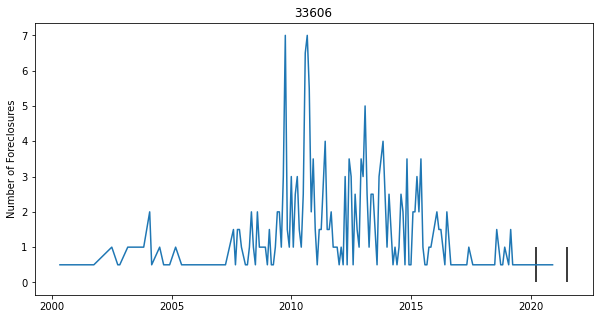

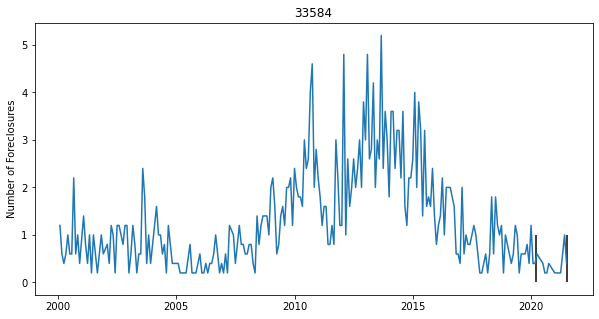

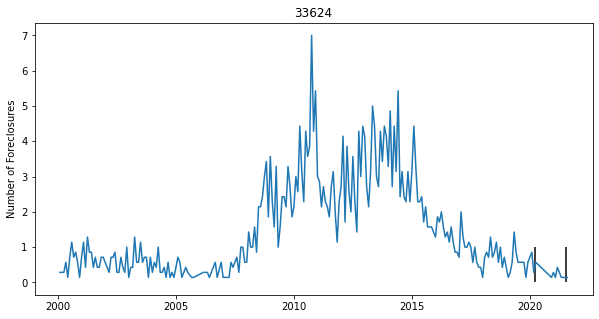

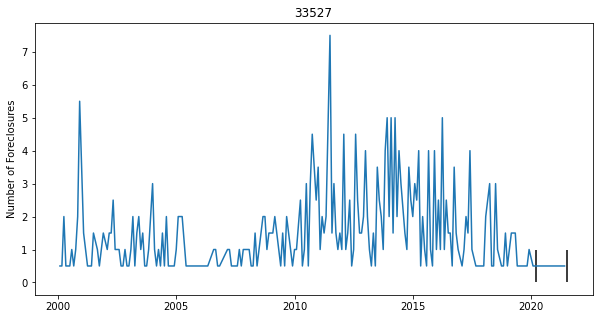

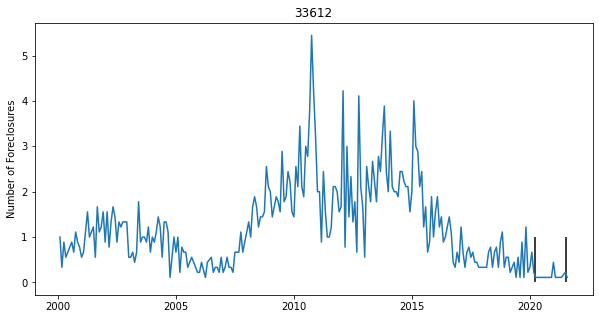

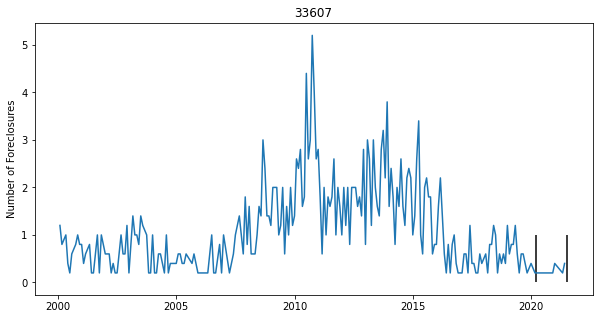

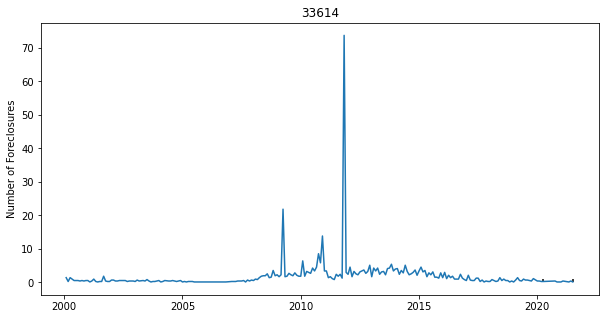

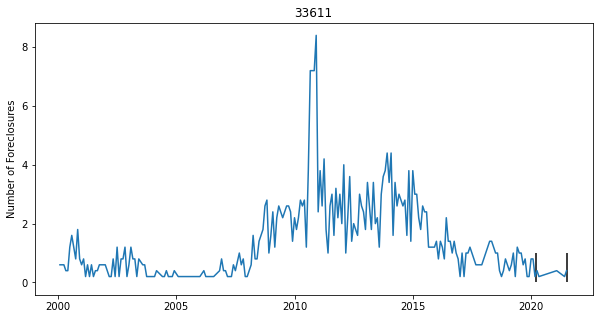

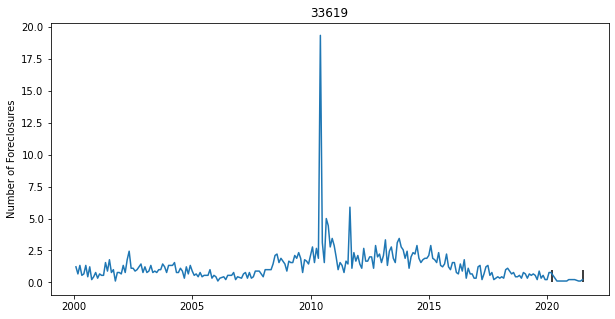

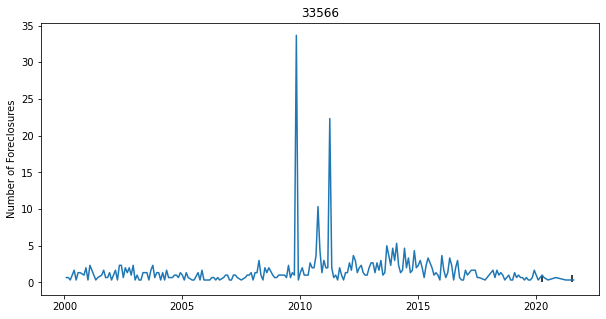

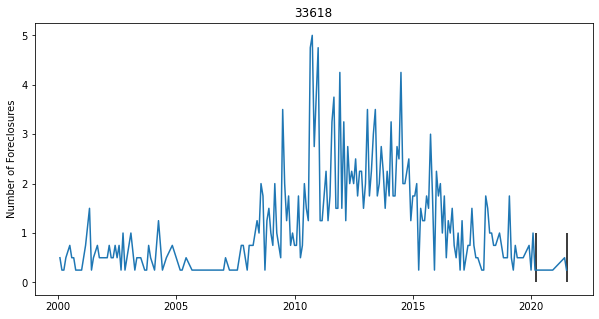

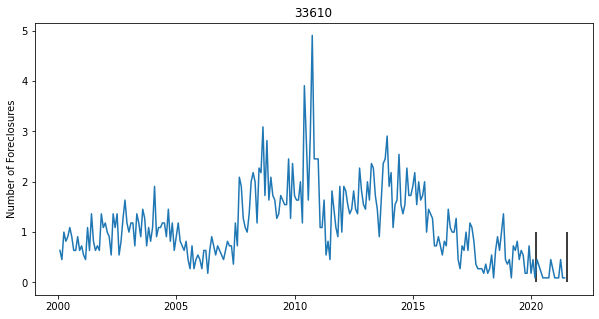

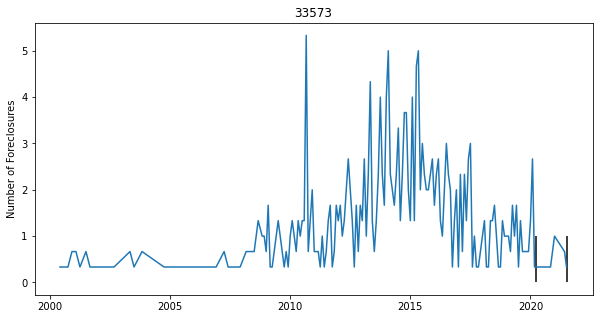

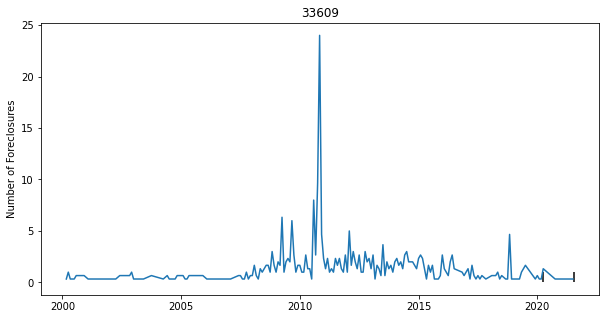

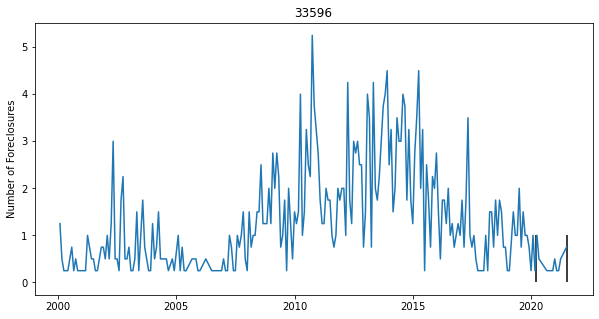

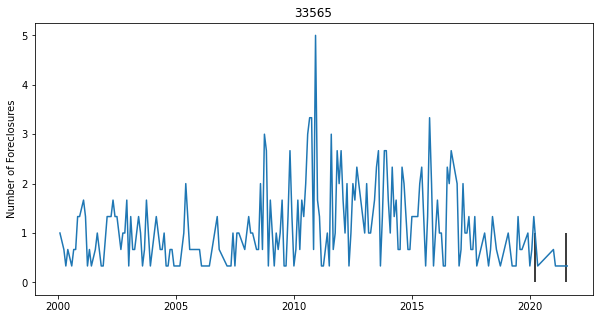

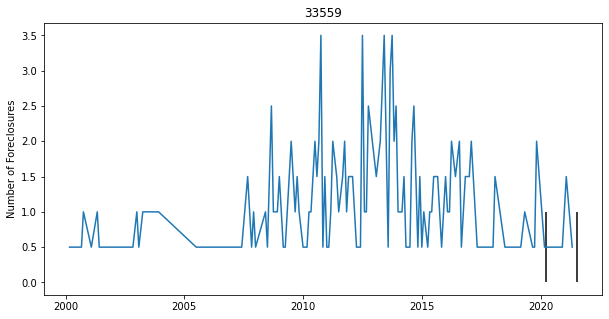

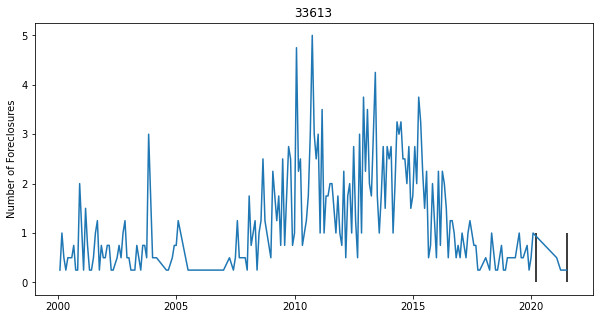

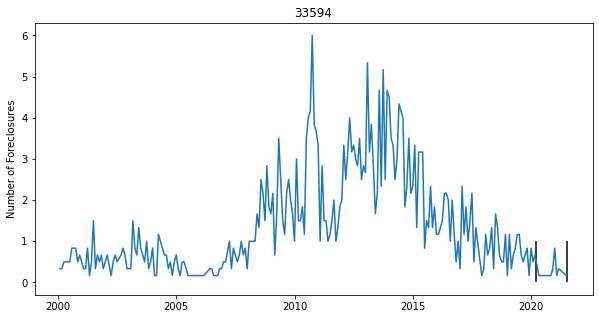

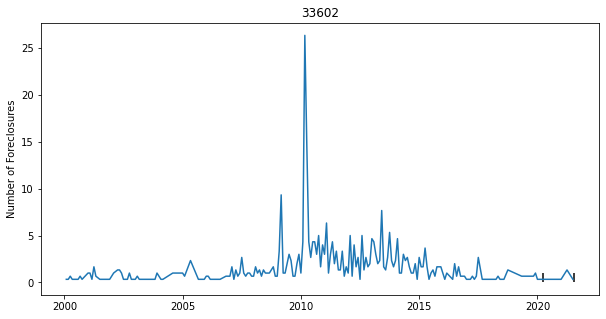

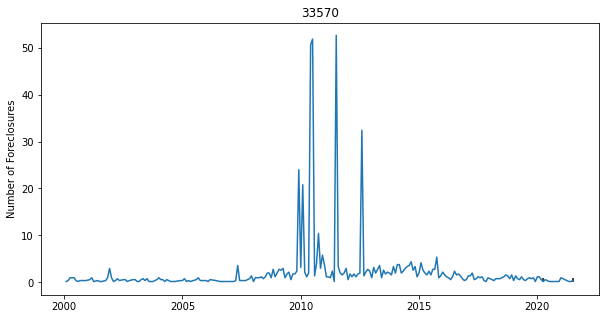

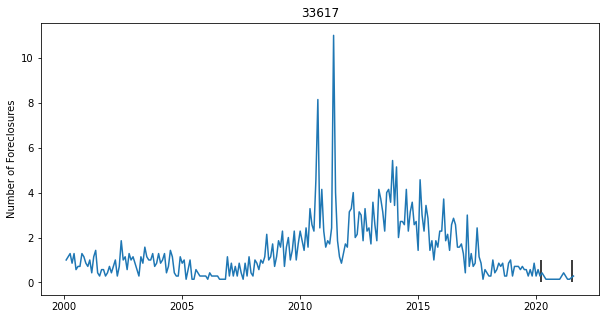

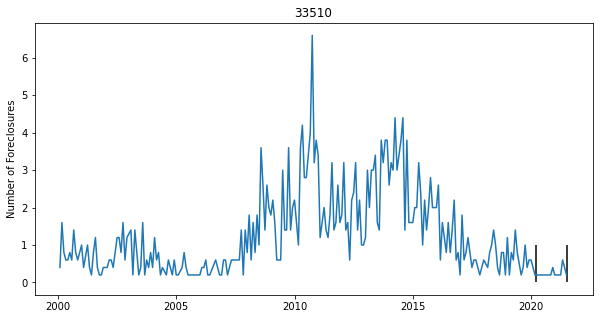

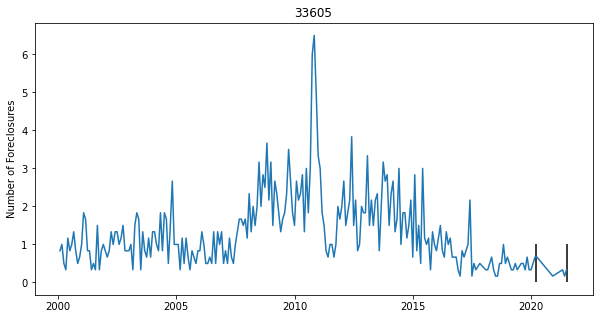

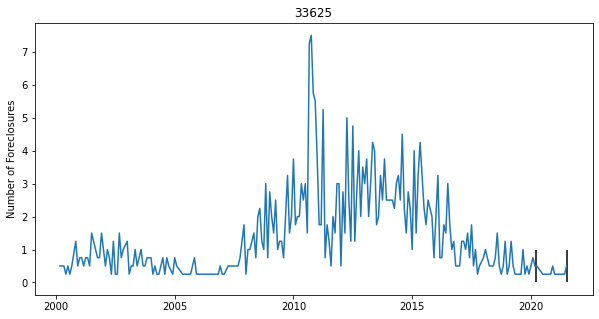

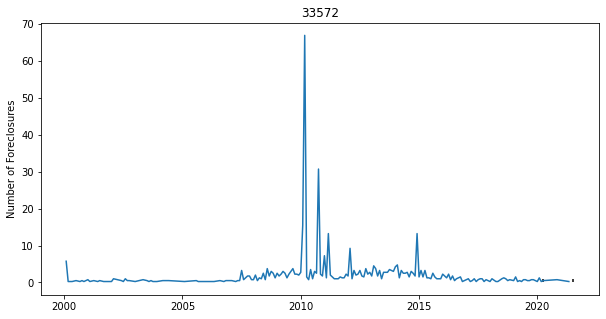

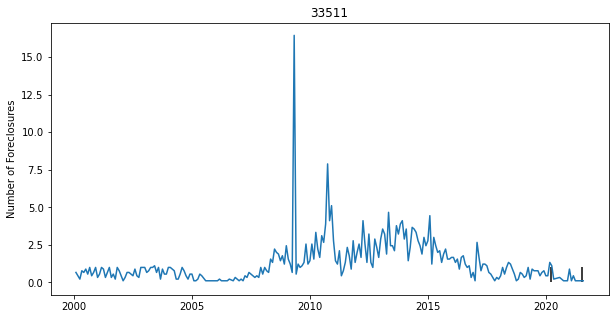

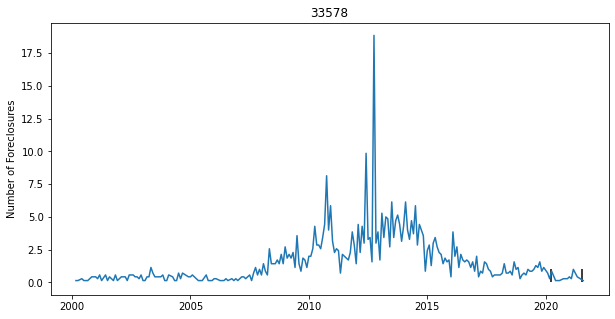

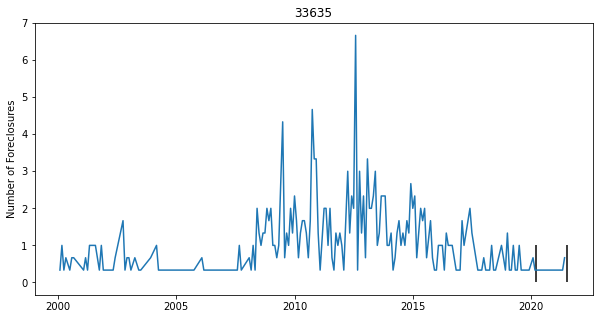

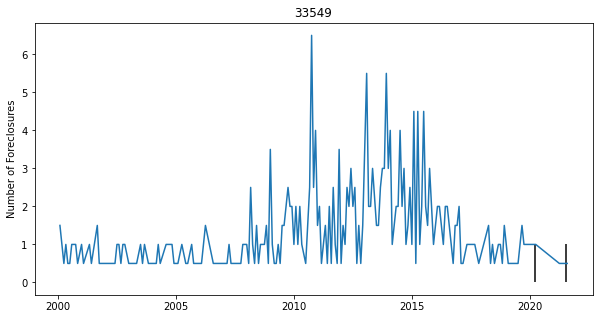

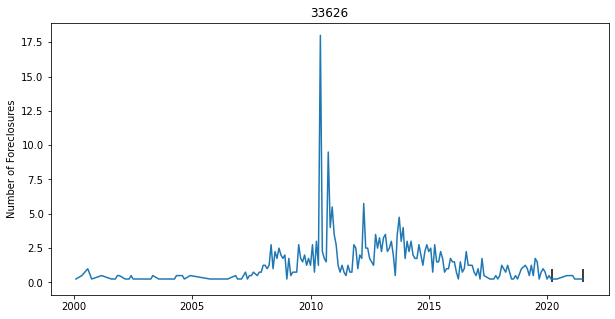

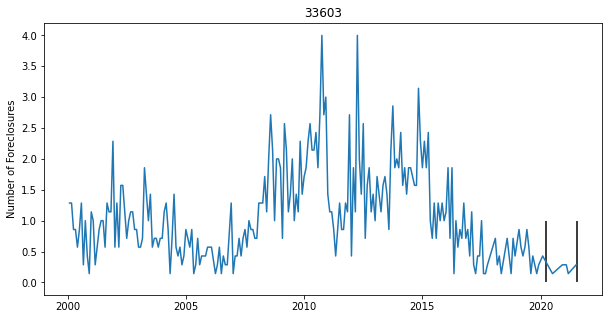

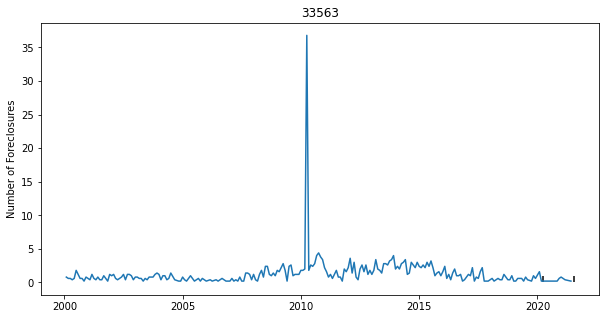

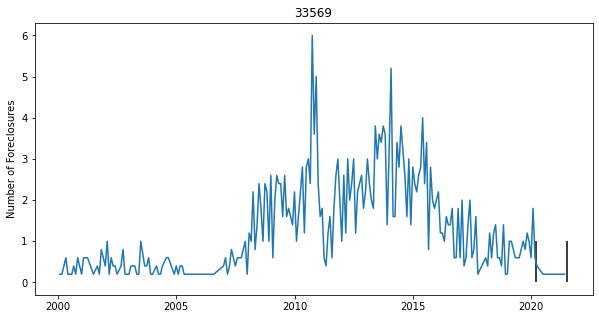

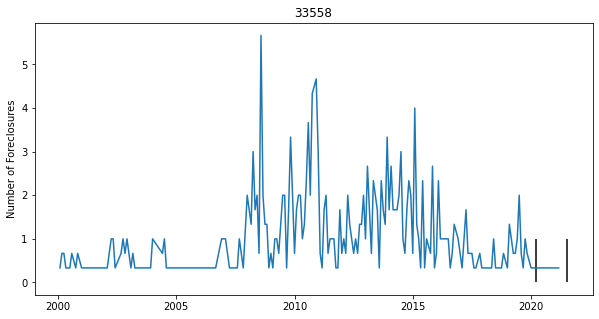

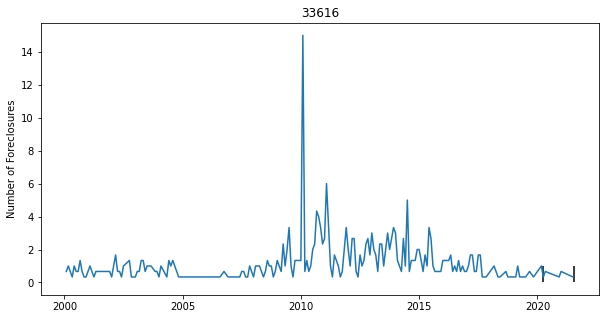

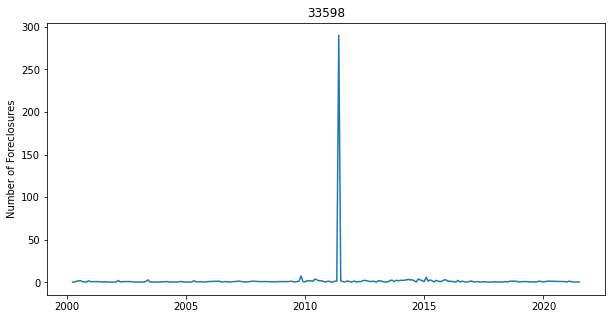

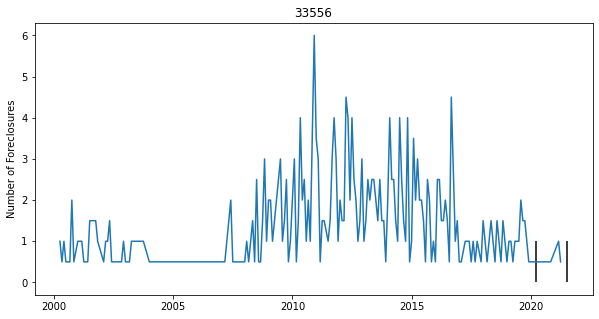

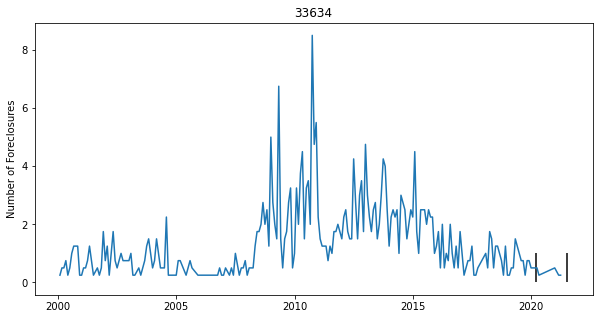

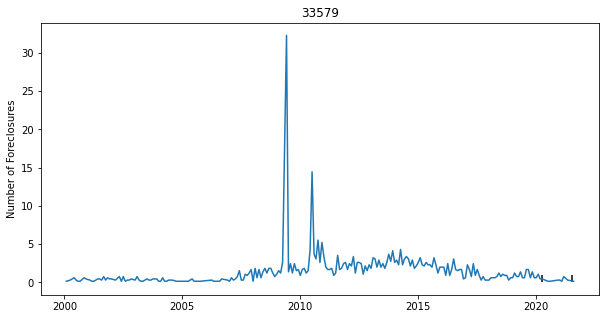

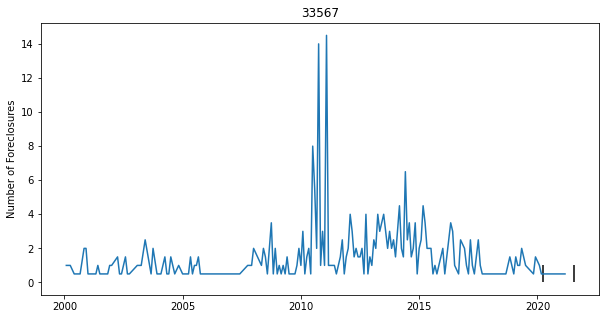

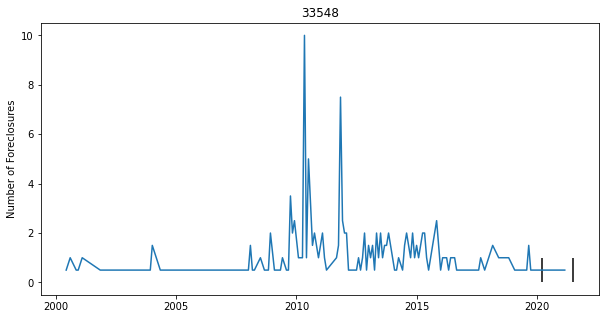

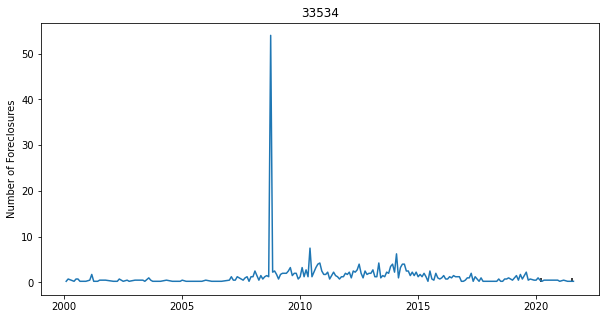

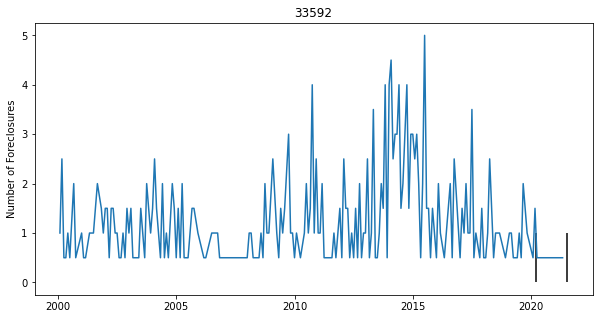

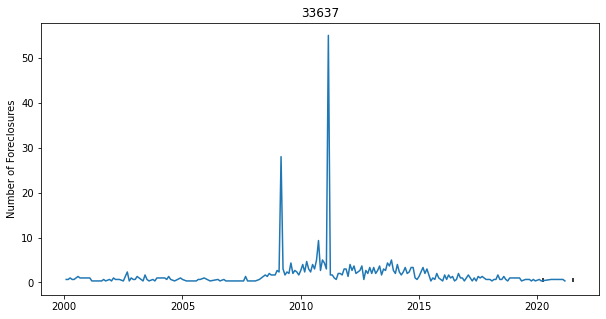

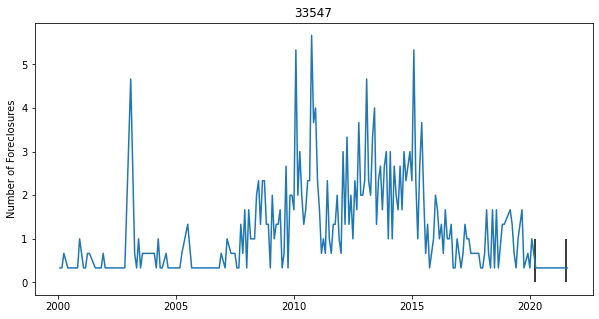

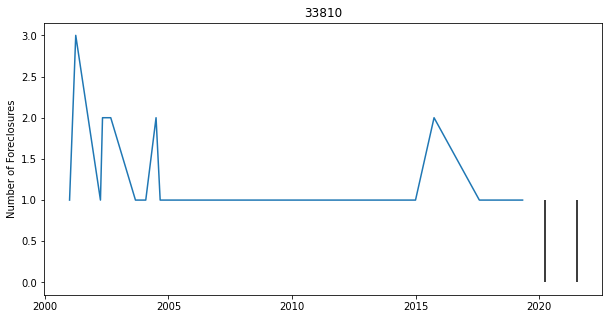

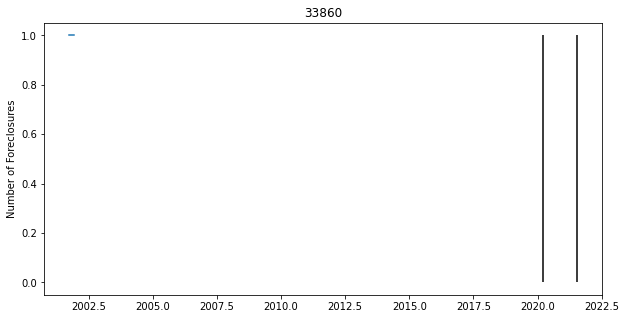

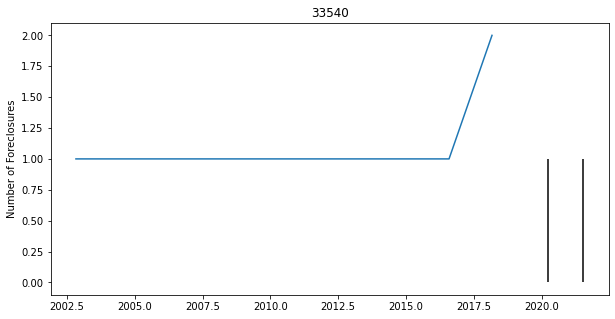

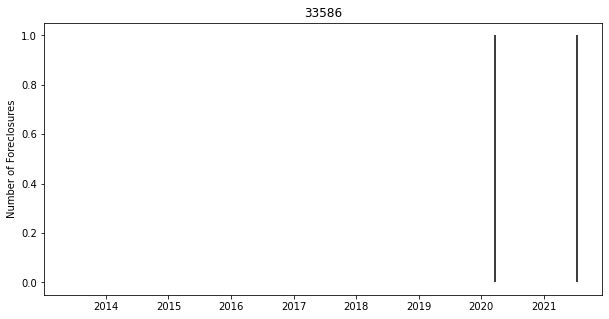

In [116]:
for zip in foreclosures_per_zip.keys():
    #print(zip)
    df = foreclosures_per_zip[zip]
    #display(df.head())
    
    fig, ax = plt.subplots(1,1,figsize=(10,5))
    ax.set_title(zip)
    ax.set_ylabel('Number of Foreclosures')
    moratorium = [2020 + (4*3)/53, 2021+(7*4)/53]
    ax.vlines(moratorium, ymin=0, ymax=1, color='black')
    ax.plot(df['foreclosures'])
    plt.show()

In [62]:
df = df[ df['S_TYPE'] == 'CT']
df.shape

(76731, 65)

In [63]:
foreclosures_per_week = df.groupby('yearweek').count()
foreclosures_per_week.shape

(1121, 64)

In [64]:
foreclosures_per_week

PIN_x  FOLIO  DOR_CODE  NBHC_x  S_DATE_x  VI_x   QU  REA_CD  \
yearweek                                                                   
2000.018868     45     45        45      45        45    45   45      45   
2000.037736     45     45        45      45        45    45   45      45   
2000.056604     22     22        22      22        22    22   22      22   
2000.075472     48     48        48      48        48    48   48      48   
2000.094340     16     16        16      16        16    16   16      16   
2000.113208     45     45        45      45        45    45   45      45   
2000.132075     15     15        15      15        15    15   15      15   
2000.150943     46     46        46      46        46    46   46      46   
2000.169811     29     29        29      29        29    29   29      29   
2000.188679     28     28        28      28        28    28   28      28   
2000.207547     33     33        33      33        33    33   33      33   
2000.226415     29     29        29      29        29    29   29      29   
2000.245283     44     44        44      44        44    44   44      44   
2000.264151     36     36        36      36        36    36   36      36   
2000.283019     21     21        21      21        21    21   21      21   
2000.301887     15     15        15      15        15    15   15      15   
2000.320755     46     46        46      46        46    46   46      46   
2000.339623     28     28        28      28        28    28   28      28   
2000.358491     33     33        33      33        33    33   33      33   
2000.377358     41     41        41      41        41    41   41      41   
2000.396226     25     25        25      25        25    25   25      25   
2000.415094     28     28        28      28        28    28   28      27   
2000.433962     28     28        28      28        28    28   28      27   
2000.452830     22     22        22      22        22    22   22      21   
2000.471698     34     34        34      34        34    34   34      31   
2000.490566     40     40        40      40        40    40   40      37   
2000.509434     45     45        45      45        45    45   45      43   
2000.528302     31     31        31      31        31    31   31      30   
2000.547170     35     35        35      35        35    35   35      35   
2000.566038     40     40        40      40        40    40   40      38   
2000.584906     24     24        24      24        24    24   24      22   
2000.603774     31     31        31      31        31    31   31      28   
2000.622642     32     32        32      32        32    32   32      31   
2000.641509     42     42        42      42        42    42   42      41   
2000.660377     34     34        34      34        34    34   34      34   
2000.679245     33     33        33      33        33    33   33      31   
2000.698113     26     26        26      26        26    26   26      25   
2000.716981     30     30        30      30        30    30   30      30   
2000.735849     41     41        41      41        41    41   41      40   
2000.754717     33     33        33      33        33    33   33      33   
2000.773585     24     24        24      24        24    24   24      23   
2000.792453     33     33        33      33        33    33   33      32   
2000.811321     33     33        33      33        33    33   33      31   
2000.830189     37     37        37      37        37    37   37      37   
2000.849057     40     40        40      40        40    40   40      40   
2000.867925     48     48        48      48        48    48   48      48   
2000.886792     10     10        10      10        10    10   10       9   
2000.905660     38     38        38      38        38    38   38      37   
2000.924528     36     36        36      36        36    36   36      36   
2000.943396     20     20        20      20        20    20   20      19   
2000.962264     38     38        38      38        38    38  

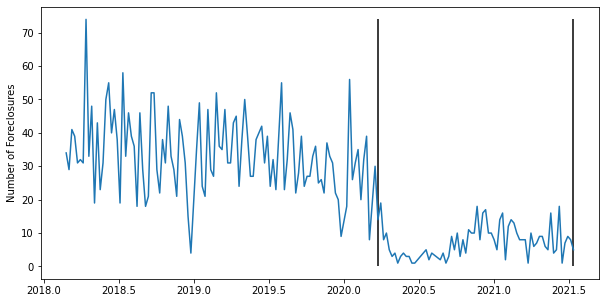

In [81]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.set_ylabel('Number of Foreclosures')
moratorium = [2020 + (4*3)/53, 2021+(7*4)/53]
ax.vlines(moratorium, ymin=0, ymax=np.array(foreclosures_per_week['PIN_x'].iloc[-175:]).max(), color='black')
ax.plot(foreclosures_per_week['PIN_x'].iloc[-175:])

In [4]:
rea_cd_autoencoder = REA_CD_Autoencoder('../models/encoders/')

In [5]:
rea_encoded_df = rea_cd_autoencoder.encode_rea_cd_in_df(sales_and_parcels)

got OHE values
got encoded values


In [6]:
rea_encoded_df.head()

PIN_x       FOLIO DOR_CODE    NBHC_x  \
1369672  U-19-29-21-ZZZ-000004-07380.0  0855870200     0100  220005.0   
1354557  U-35-28-21-ZZZ-000003-87990.0  0839190200     0200  221001.0   
2064848  T-15-28-19-54X-000009-00007.0  2007630187     0400  817029.0   
2110431  P-20-28-22-5B7-000002-00005.0  2056440000     0100  221008.0   
592814   U-33-28-19-1M2-000000-00006.3  0398100200     0000  218008.0   

           S_DATE_x VI_x QU  S_AMT_x SUB_x     STR S_TYPE  OR_BK OR_PG  \
1369672  1901-12-01    I  U    100.0   ZZZ  192921     DD  06468  0182   
1354557  1902-02-01    V  U  22500.0   ZZZ  352821     WD  06498  1093   
2064848  1902-03-01    I  U   1000.0   54X  152819     CT  06560  1266   
2110431  1903-05-01    I  U    100.0   5B7  202822     QC  06978  1229   
592814   1904-11-01    V  U    100.0   1M2  332819     WD  04442  0588   

        GRANTOR GRANTEE   DOC_NUM  TYPE                          PIN_y DOR_C  \
1369672    None    None  91259894  None  U-19-29-21-ZZZ-000004-07380.0  0100   
1354557    None    None  92017529  None  U-35-28-21-ZZZ-000003-87990.0  0200   
2064848    None    None  92065551  None  T-15-28-19-54X-000009-00007.0  0400   
2110431    None    None  93111152  None  P-20-28-22-5B7-000002-00005.0  0100   
592814     None    None      None  None  U-33-28-19-1M2-000000-00006.3  0000   

                          OWNER                  ADDR_1 ADDR_2  \
1369672   136 N SAINT CLOUD LLC       4252 GREEN KEY RD   None   
1354557   JOSE A SANTIAGO ET AL       1412 WILKINSON DR   None   
2064848       ARRIE ADEL POTTER  11334 STRATTON PARK DR   None   
2110431  JAMES AND JAMIE HUDSON      1306 N FRANKLIN ST   None   
592814        MYRNAMAE ENGLETON    6002 N 50TH ST APT A   None   

                    CITY STATE         ZIP COUNTRY SUB_y  \
1369672  NEW PORT RICHEY    FL  34652-2074    None   ZZZ   
1354557       PLANT CITY    FL  33566-7917    None   ZZZ   
2064848            TAMPA    FL  33617-2392    None   54X   
2110431       PLANT CITY    FL  33563-2252    None   5B7   
592814             TAMPA    FL  33610-3941    None   1M2   

                      SITE_ADDR       SITE_CITY SITE_ZIP  \
1369672     136 SAINT CLOUD AVE         VALRICO    33594   
1354557       1412 WILKINSON DR      PLANT CITY    33566   
2064848  11334 STRATTON PARK DR  TEMPLE TERRACE    33617   
2110431      1306 N FRANKLIN ST      PLANT CITY    33563   
592814           6002 N 50TH ST           TAMPA    33610   

                                                    LEGAL1  \
1369672  BEG 25 FT W & 468.92 FT N OF SE COR OF SE 1/4 RUN   
1354557     COMM SW COR OF E 3/4 OF NE 1/4 OF SW 1/4 THN E   
2064848                     VICTORIA TERRACE A CONDOMINIUM   
2110431                                           OAK HILL   
592814                                    BENS SUBDIVISION   

                                                    LEGAL2  \
1369672     W 194 FT N 52 FT W 110 FT N 77 FT E 304 FT AND   
1354557  25 FT THN N 157.16 FT FOR POB THN CON N 244.85 FT   
2064848                                            PHASE 2   
2110431                                      LOT 5 BLOCK 2   
592814                    NORTH HALF OF LOT 6 LESS N 50 FT   

                                                 LEGAL3  \
1369672                                 S 131 FT TO POB   
1354557  THN N 88 DEG 54 MIN 39 SEC E 157.83 FTTHN S 20   
2064848                                          BLDG 9   
2110431                                            None   
592814                                             None   

                                                   LEGAL4   DBA  \
1369672                                              None  None   
1354557  DEG 34 MIN 03 SEC E 264.70 FT THN W 248.53 FT TO  None   
2064848                                            UNIT 7  None   
2110431                                              None  None   
592814                                               None  None   

                          STRAP  tBEDS  tBATH

array(['34652-2074', '33566-7917', '33617-2392', ..., '33613-1364',
       '33563-5315', '33565-2479'], dtype=object)

In [7]:
builder = SlimAutoencoderBuilder(rea_encoded_df)

In [8]:
test = builder.prepare()
test.shape

(1354991, 14)

In [10]:
builder.df_prepared.head()

NBHC_x    STR  tBEDS  tBATHS  tSTORIES  tUNITS  tBLDGS     ACT  \
774332   227002.0   7683    0.0     0.0       0.0     0.0     0.0     0.0   
784365   828065.0  -7853    1.0     1.5       1.0     1.0     0.0  1974.0   
1394453  223007.0 -14759    5.0     3.5       1.0     1.0     1.0  1981.0   
1505303  221001.0 -13686    0.0     0.0       0.0     0.0     0.0     0.0   
96990    210004.0  16209    4.0     3.0       2.0     1.0     1.0  2000.0   

            EFF  HEAT_AR    BASE   ACREAGE  REA_CD_encoded_x  REA_CD_encoded_y  
774332      0.0      0.0     0.0  0.397661          0.000000          7.271828  
784365   1997.0    800.0  2020.0  0.016733          4.368667          0.000000  
1394453  2001.0   3402.0  2001.0  0.838639          0.000000          2.445443  
1505303     0.0      0.0     0.0  2.559050          0.000000          2.445443  
96990    2014.0   2902.0  2017.0  0.165285          0.000000          7.271828

In [13]:
builder.model_autoencoder = tf.keras.models.load_model('../models/encoders/SlimAutoencoder2')
builder.model_decoder = tf.keras.models.load_model('../models/encoders/SlimDecoder2')
builder.model_encoder = tf.keras.models.load_model('../models/encoders/SlimEncoder2')

In [15]:
encodings = builder.model_encoder.predict(builder.df)
encodings.shape
builder.autoencoded = pd.DataFrame(data={'Dates':builder.dates.copy(),'encoded_x':encodings[:,0], 'encoded_y':encodings[:,1]})
builder.autoencoded.shape

(1354991, 3)

In [19]:
builder.autoencoded[-2:]
builder.autoencoded_scaler = StandardScaler()
builder.autoencoded_scaler.fit(builder.autoencoded.iloc[:,1:])
builder.autoencoded_scaled = builder.autoencoded_scaler.transform(builder.autoencoded.iloc[:,1:])
builder.autoencoded_scaled.shape
builder.autoencoded_scaled = pd.DataFrame({'Dates': builder.autoencoded['Dates'], 
                                           'encoded_x': builder.autoencoded_scaled[:,0], 
                                           'encoded_y': builder.autoencoded_scaled[:,1]})
builder.autoencoded_scaled['Dates'] = pd.to_datetime(builder.autoencoded_scaled['Dates'])
builder.autoencoded_scaled.head()

Dates  encoded_x  encoded_y
774332  2000-01-28  -0.196108  -2.308644
784365  2000-01-28  -0.357976   1.418423
1394453 2000-01-28  -1.162551   0.493039
1505303 2000-01-28  -0.400330  -2.328980
96990   2000-01-28  -1.104502   0.537583

In [50]:
model = ConvLSTM(None)
model.loadModel('../models/cnnlstm4/')

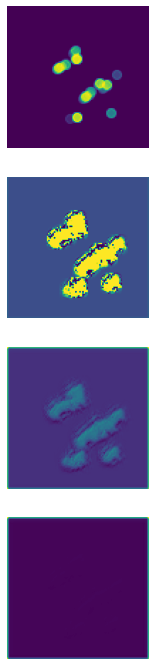

In [155]:
fig, ax, plt = model.extrapolateFromImagePath('../img/one_channel/','2007-06-06',3)

In [69]:
stats.describe(np.squeeze(predictions[1]).reshape(-1,1))

DescribeResult(nobs=10000, minmax=(array([0.], dtype=float32), array([1.], dtype=float32)), mean=array([0.35546863], dtype=float32), variance=array([0.07375627], dtype=float32), skewness=array([1.7618928], dtype=float32), kurtosis=array([1.4822044], dtype=float32))

In [145]:
prediction = model.predictions[1]
threshold = .5
print(prediction.shape)
#xy = np.zeros((prediction.shape[2],prediction.shape[3]))
xy = []

for x in range(prediction.shape[2]):
    for y in range(prediction.shape[3]):
        if prediction[0][0][x][y][0] > threshold:
            xy.append([x,y])
            
print(len(xy))
xy= np.array(xy)
xy.shape


(1, 1, 100, 100, 1)
1142


(1142, 2)

In [146]:
decoded_predictions = builder.model_decoder.predict(xy)

In [147]:
decoded_predictions.shape
decoded_predictions = builder.scaler.inverse_transform(decoded_predictions)

In [148]:
decoded_predictions_df = pd.DataFrame(decoded_predictions, columns=builder.columns_linear)

In [149]:
decoded_predictions_df 

NBHC_x           STR      tBEDS    tBATHS  tSTORIES     tUNITS  \
0     3.302090e+06 -10774.839844  -3.994224  0.391835  3.163722  -0.070797   
1     3.964760e+06 -13101.528320  -5.524089  0.035885  3.553326  -0.580003   
2     4.296094e+06 -14264.864258  -6.289047 -0.142107  3.748146  -0.834827   
3     4.627428e+06 -15428.204102  -7.053914 -0.320047  3.942915  -1.088961   
4     2.854342e+06  -9202.767578  -2.960554  0.632327  2.900548   0.273062   
5     4.842350e+06 -16182.792969  -7.550094 -0.435558  4.069217  -1.253972   
6     5.173684e+06 -17346.142578  -8.315052 -0.613538  4.264016  -1.508743   
7     1.743924e+06  -5304.019531  -0.397035  1.228783  2.247728   1.126233   
8     2.075259e+06  -6467.357910  -1.161927  1.050806  2.442508   0.871621   
9     2.406594e+06  -7630.701660  -1.926905  0.872833  2.637325   0.617010   
10    3.069264e+06  -9957.379883  -3.456724  0.516884  3.026864   0.107981   
11    4.063267e+06 -13447.390625  -5.751527 -0.017059  3.611241  -0.655625   
12    4.394602e+06 -14610.738281  -6.516474 -0.195071  3.806034  -0.910342   
13    4.725937e+06 -15774.078125  -7.281342 -0.373008  4.000844  -1.164760   
14    9.648399e+05  -2568.605957   1.401523  1.647272  1.789724   1.724651   
15    1.296175e+06  -3731.938232   0.636645  1.469285  1.984497   1.470287   
16    1.627510e+06  -4895.281738  -0.128282  1.291307  2.179296   1.215693   
17    2.621515e+06  -8385.303711  -2.423084  0.757365  2.763685   0.451734   
18    2.952848e+06  -9548.624023  -3.187997  0.579393  2.958454   0.197405   
19    3.284184e+06 -10711.984375  -3.952894  0.401436  3.153228  -0.057207   
20    3.615518e+06 -11875.302734  -4.717842  0.223423  3.347985  -0.311659   
21    3.946853e+06 -13038.671875  -5.482789  0.045486  3.542830  -0.566430   
22    4.278188e+06 -14201.990234  -6.247666 -0.132486  3.737590  -0.820865   
23    4.609523e+06 -15365.345703  -7.012574 -0.310464  3.932386  -1.075583   
24    3.679172e+05  -1072.204834  -0.941792  0.774768  3.036912 -12.883331   
25    8.484269e+05  -2159.869873   1.670295  1.709792  1.721284   1.814164   
26    1.511097e+06  -4486.547852   0.140450  1.353857  2.110873   1.305046   
27    1.842432e+06  -5649.893555  -0.624467  1.175880  2.305668   1.050452   
28    2.173766e+06  -6813.228027  -1.389379  0.997872  2.500447   0.795858   
29    2.505100e+06  -7976.567871  -2.154317  0.819915  2.695236   0.541353   
30    2.836435e+06  -9139.902344  -2.919239  0.641943  2.889998   0.286865   
31    3.167770e+06 -10303.255859  -3.684257  0.463930  3.084831   0.031811   
32    3.499105e+06 -11466.574219  -4.449049  0.285968  3.279565  -0.222147   
33    3.830440e+06 -12629.923828  -5.214036  0.107960  3.474356  -0.476882   
34    4.161775e+06 -13793.262695  -5.978873 -0.069982  3.669167  -0.731635   
35    4.493110e+06 -14956.596680  -6.743781 -0.247954  3.863918  -0.985770   
36    1.063348e+06  -2914.474121   1.174151  1.594359  1.847638   1.649047   
37    1.394683e+06  -4077.810303   0.409213  1.416377  2.042437   1.394364   
38    1.726018e+06  -5241.153809  -0.355694  1.238404  2.237221   1.139912   
39    2.057351e+06  -6404.484375  -1.120612  1.060432  2.432006   0.885424   
40    2.388686e+06  -7567.828125  -1.885549  0.882434  2.626783   0.630812   
41    2.720022e+06  -8731.171875  -2.650476  0.704482  2.821606   0.376077   
42    3.051356e+06  -9894.513672  -3.415424  0.526469  3.016371   0.121624   
43    3.382692e+06 -11057.840820  -4.180321  0.348512  3.211157  -0.132988   
44    3.714026e+06 -12221.176758  -4.945269  0.170545  3.405947  -0.387387   
45    4.045361e+06 -13384.528320  -5.710186 -0.007437  3.600708  -0.642176   
46    3.291376e+05  -1574.602783  -4.816508 -0.475398  4.716530 -28.903563   
47    3.843246e+05   -859.646912   0.697558  1.303690  2.326287  -6.105450   
48    6.156001e+05  -1342.401978   2.207770  1.834835  1.584420   1.992977   
49    9.469351e+05  -2505.734131   1.442883  1.656868  1.779192   1.738542   
50    1.278270e+06  -3669.078125  

In [150]:
decoded_predictions_df = rea_cd_autoencoder.decode_rea_cd_in_df(decoded_predictions_df)

In [151]:
decoded_predictions_df

NBHC_x           STR      tBEDS    tBATHS  tSTORIES     tUNITS  \
0     3.302090e+06 -10774.839844  -3.994224  0.391835  3.163722  -0.070797   
1     3.964760e+06 -13101.528320  -5.524089  0.035885  3.553326  -0.580003   
2     4.296094e+06 -14264.864258  -6.289047 -0.142107  3.748146  -0.834827   
3     4.627428e+06 -15428.204102  -7.053914 -0.320047  3.942915  -1.088961   
4     2.854342e+06  -9202.767578  -2.960554  0.632327  2.900548   0.273062   
5     4.842350e+06 -16182.792969  -7.550094 -0.435558  4.069217  -1.253972   
6     5.173684e+06 -17346.142578  -8.315052 -0.613538  4.264016  -1.508743   
7     1.743924e+06  -5304.019531  -0.397035  1.228783  2.247728   1.126233   
8     2.075259e+06  -6467.357910  -1.161927  1.050806  2.442508   0.871621   
9     2.406594e+06  -7630.701660  -1.926905  0.872833  2.637325   0.617010   
10    3.069264e+06  -9957.379883  -3.456724  0.516884  3.026864   0.107981   
11    4.063267e+06 -13447.390625  -5.751527 -0.017059  3.611241  -0.655625   
12    4.394602e+06 -14610.738281  -6.516474 -0.195071  3.806034  -0.910342   
13    4.725937e+06 -15774.078125  -7.281342 -0.373008  4.000844  -1.164760   
14    9.648399e+05  -2568.605957   1.401523  1.647272  1.789724   1.724651   
15    1.296175e+06  -3731.938232   0.636645  1.469285  1.984497   1.470287   
16    1.627510e+06  -4895.281738  -0.128282  1.291307  2.179296   1.215693   
17    2.621515e+06  -8385.303711  -2.423084  0.757365  2.763685   0.451734   
18    2.952848e+06  -9548.624023  -3.187997  0.579393  2.958454   0.197405   
19    3.284184e+06 -10711.984375  -3.952894  0.401436  3.153228  -0.057207   
20    3.615518e+06 -11875.302734  -4.717842  0.223423  3.347985  -0.311659   
21    3.946853e+06 -13038.671875  -5.482789  0.045486  3.542830  -0.566430   
22    4.278188e+06 -14201.990234  -6.247666 -0.132486  3.737590  -0.820865   
23    4.609523e+06 -15365.345703  -7.012574 -0.310464  3.932386  -1.075583   
24    3.679172e+05  -1072.204834  -0.941792  0.774768  3.036912 -12.883331   
25    8.484269e+05  -2159.869873   1.670295  1.709792  1.721284   1.814164   
26    1.511097e+06  -4486.547852   0.140450  1.353857  2.110873   1.305046   
27    1.842432e+06  -5649.893555  -0.624467  1.175880  2.305668   1.050452   
28    2.173766e+06  -6813.228027  -1.389379  0.997872  2.500447   0.795858   
29    2.505100e+06  -7976.567871  -2.154317  0.819915  2.695236   0.541353   
30    2.836435e+06  -9139.902344  -2.919239  0.641943  2.889998   0.286865   
31    3.167770e+06 -10303.255859  -3.684257  0.463930  3.084831   0.031811   
32    3.499105e+06 -11466.574219  -4.449049  0.285968  3.279565  -0.222147   
33    3.830440e+06 -12629.923828  -5.214036  0.107960  3.474356  -0.476882   
34    4.161775e+06 -13793.262695  -5.978873 -0.069982  3.669167  -0.731635   
35    4.493110e+06 -14956.596680  -6.743781 -0.247954  3.863918  -0.985770   
36    1.063348e+06  -2914.474121   1.174151  1.594359  1.847638   1.649047   
37    1.394683e+06  -4077.810303   0.409213  1.416377  2.042437   1.394364   
38    1.726018e+06  -5241.153809  -0.355694  1.238404  2.237221   1.139912   
39    2.057351e+06  -6404.484375  -1.120612  1.060432  2.432006   0.885424   
40    2.388686e+06  -7567.828125  -1.885549  0.882434  2.626783   0.630812   
41    2.720022e+06  -8731.171875  -2.650476  0.704482  2.821606   0.376077   
42    3.051356e+06  -9894.513672  -3.415424  0.526469  3.016371   0.121624   
43    3.382692e+06 -11057.840820  -4.180321  0.348512  3.211157  -0.132988   
44    3.714026e+06 -12221.176758  -4.945269  0.170545  3.405947  -0.387387   
45    4.045361e+06 -13384.528320  -5.710186 -0.007437  3.600708  -0.642176   
46    3.291376e+05  -1574.602783  -4.816508 -0.475398  4.716530 -28.903563   
47    3.843246e+05   -859.646912   0.697558  1.303690  2.326287  -6.105450   
48    6.156001e+05  -1342.401978   2.207770  1.834835  1.584420   1.992977   
49    9.469351e+05  -2505.734131   1.442883  1.656868  1.779192   1.738542   
50    1.278270e+06  -3669.078125  

In [152]:
decoded_predictions_df = decoded_predictions_df[ decoded_predictions_df['tBEDS'] >= 0]
decoded_predictions_df = decoded_predictions_df[ decoded_predictions_df['tSTORIES'] >= 0]
decoded_predictions_df = decoded_predictions_df[ decoded_predictions_df['tBATHS'] >= 0]
decoded_predictions_df = decoded_predictions_df[ decoded_predictions_df['tUNITS'] >= 0]
decoded_predictions_df = decoded_predictions_df[ decoded_predictions_df['tBLDGS'] >= 0]
#decoded_predictions_df = decoded_predictions_df[ decoded_predictions_df['ACT'] >= 0]
#decoded_predictions_df = decoded_predictions_df[ decoded_predictions_df['EFF'] >= 0]
#decoded_predictions_df = decoded_predictions_df[ decoded_predictions_df['HEAT_AR'] >= 0]
#decoded_predictions_df = decoded_predictions_df[ decoded_predictions_df['BASE'] >= 0]
#decoded_predictions_df = decoded_predictions_df[ decoded_predictions_df['ACREAGE'] >= 0]

In [153]:
decoded_predictions_df.shape

(26, 13)

In [154]:
decoded_predictions_df

NBHC_x          STR     tBEDS    tBATHS  tSTORIES    tUNITS  \
14   964839.87500 -2568.605957  1.401523  1.647272  1.789724  1.724651   
25   848426.93750 -2159.869873  1.670295  1.709792  1.721284  1.814164   
48   615600.12500 -1342.401978  2.207770  1.834835  1.584420  1.992977   
49   946935.06250 -2505.734131  1.442883  1.656868  1.779192  1.738542   
61   499186.15625  -933.658264  2.476563  1.897390  1.515974  2.082542   
62   830521.31250 -2097.002197  1.711646  1.719413  1.710775  1.827931   
77   400732.12500  -647.079163  2.336969  1.832642  1.615657  0.672697   
78   714106.75000 -1688.258545  1.980378  1.781942  1.642323  1.917390   
93   597693.81250 -1279.524536  2.249141  1.844467  1.573882  2.006797   
94   929028.87500 -2442.872314  1.484193  1.666494  1.768704  1.752291   
107  481280.65625  -870.792480  2.517893  1.906996  1.505448  2.096239   
108  812615.87500 -2034.136475  1.752966  1.729029  1.700249  1.841645   
121  696201.12500 -1625.392700  2.021719  1.791558  1.631796  1.931069   
139  579788.12500 -1216.664551  2.290471  1.854083  1.563373  2.020511   
140  911123.12500 -2379.998779  1.525574  1.676121  1.758142  1.766058   
161  463375.18750  -807.926697  2.559234  1.916622  1.494930  2.109918   
162  794708.56250 -1971.262817  1.794296  1.738650  1.689715  1.855324   
414  508164.31250  -965.179932  2.455822  1.892542  1.521251  2.075562   
437  723084.68750 -1719.786011  1.959668  1.777124  1.647607  1.910392   
464  606671.75000 -1311.048096  2.228400  1.839633  1.579159  1.999869   
465  938006.75000 -2474.390137  1.463503  1.661666  1.773947  1.745381   
489  490258.78125  -902.314087  2.497153  1.902173  1.510717  2.089382   
490  821592.18750 -2065.648193  1.732245  1.724206  1.705503  1.834858   
511  399244.87500  -666.345520  2.188369  1.784698  1.680072  0.058249   
512  705179.25000 -1656.914307  2.000978  1.786725  1.637076  1.924212   
533  588764.56250 -1248.172485  2.269771  1.849259  1.568628  2.013742   

       tBLDGS          ACT          EFF      HEAT_AR        BASE   ACREAGE  \
14   0.021247  2008.866821  2020.404785  4706.320801 -229.631363 -0.738212   
25   0.199065  2007.996704  2020.756592  4554.907715 -199.472397 -0.259381   
48   0.554684  2006.257080  2021.459717  4252.042480 -139.154343  0.698007   
49   0.048591  2008.732788  2020.458984  4682.791504 -224.992676 -0.664058   
61   0.732508  2005.386841  2021.811890  4100.667969 -108.995026  1.177022   
62   0.226412  2007.862427  2020.810547  4531.650391 -194.833496 -0.185227   
77   0.850976  1967.121094  1980.269165  4764.063965  -83.820114 -3.147623   
78   0.404227  2006.993164  2021.162354  4380.159668 -164.674271  0.293145   
93   0.582040  2006.122437  2021.513672  4228.746582 -134.515228  0.771977   
94   0.075946  2008.598755  2020.512695  4659.631836 -220.353912 -0.590456   
107  0.759856  2005.252686  2021.865356  4077.489014 -104.356262  1.250625   
108  0.253765  2007.729004  2020.864746  4508.413086 -190.194946 -0.112175   
121  0.431574  2006.859253  2021.216309  4356.688477 -160.035522  0.366564   
139  0.609389  2005.989136  2021.568115  4205.586914 -129.876541  0.845120   
140  0.103297  2008.464844  2020.566895  4636.335938 -215.714874 -0.516853   
161  0.787206  2005.118896  2021.919800  4054.329590  -99.717575  1.324135   
162  0.281110  2007.594971  2020.918457  4485.136719 -185.555710 -0.038481   
414  0.718791  2005.453857  2021.784424  4112.131348 -111.321106  1.139807   
437  0.390513  2007.060059  2021.134888  4391.856445 -167.000153  0.256114   
464  0.568327  2006.189941  2021.486694  4240.384766 -136.841263  0.734762   
465  0.062233  2008.665894  2020.485718  4671.308594 -222.679657 -0.627670   
489  0.746138  2005.319824  2021.838379  4088.815918 -106.682251  1.213502   
490  0.240049  2007.795532  2020.837280  4519.934570 -192.520248 -0.148655   
511  0.840021  1951.558228  1962.935547  5089.816406  -83.572205 -5.101267   
512  0.417856  2006.926025  2021.189331  4368.462891 -162.3614